In [1]:
N_CLONES = 2000
DB_PATH = f"../data/synthetic/raw/cld_{N_CLONES}clones.db"

# Notebook 04 - Early Clone Drop Simulation (Decision Impact)

## Goal
Convert ML predictions into a practical CLD design policy and quantify impact.

We simulate early clone filtering using two retention policies:
- **Top 20%** retained (drop 80%) - conservative
- **Top 10%** retained (drop 90%) - aggresive

We compare multiple selection strategies:
1) **BaseLine A: Early titer ranking** (common in practice)
2) **Baseline B: Random selection** (sanitiy baseline)
3) **ML-guided selection** (use model predictions)

## Why this matters
A model is only valuable if it improves real decisions:
- reduces CLD cost and time (fewer clones advanced)
- maintains or improves late-stage outcomes (stability, productivity, quality)

This notebook quantifies that value.

## 1) Imports

We use Pandas/Numpy for data handling and scikit-learn for training a single model used in the simulation (regression model predicting stability drop).


In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

## 02) Load ML dataset and connect to SQLite DB

- ML dataset: 'cld_features_with_label.csv' (from Notebook 02)
- SQLite DB: used to compute "late-stage outcomes" for selected clone sets

In [2]:
FEATURE_PATH = "../data/synthetic/processed/cld_features_with_label.csv"
dataset = pd.read_csv(FEATURE_PATH)

DB_PATH = "../data/synthetic/raw/cld.db"
conn = sqlite3.connect(DB_PATH)

dataset.head()

,clone_id,titer_mean,titer_std,titer_min,titer_max,vcd_mean,vcd_std,vcd_min,vcd_max,viability_mean,...,viability_max,aggregation_mean,aggregation_std,aggregation_min,aggregation_max,titer_slope,vcd_slope,viability_slope,aggregation_slope,productivity_drop_pct
0,CLONE_0001,2.538067,0.293036,2.223711,2.964514,1.107619e+07,9.052556e+05,9.779103e+06,1.232258e+07,94.851455,...,97.386709,8.356812,0.403848,7.723455,8.894030,-0.103703,102268.665747,0.169734,-0.019225,0.387063
1,CLONE_0002,0.814721,0.213007,0.537981,1.132518,1.441091e+07,1.047019e+06,1.346070e+07,1.605341e+07,97.551824,...,99.573812,7.337188,0.449925,6.798531,8.011004,-0.005035,279733.381794,0.198861,-0.023819,0.135156
2,CLONE_0003,3.912552,0.208697,3.621956,4.261524,8.684126e+06,5.834120e+05,7.780120e+06,9.384241e+06,94.390688,...,98.774683,2.235352,0.326064,1.745532,2.861836,-0.058117,51853.805966,0.505344,0.038583,0.335258
3,CLONE_0004,0.488369,0.160312,0.212916,0.747609,1.511725e+07,7.817665e+05,1.405453e+07,1.606425e+07,96.380534,...,98.968096,3.860240,0.305128,3.357574,4.286918,-0.026671,278866.456374,0.504642,0.051834,0.590633
4,CLONE_0005,2.238289,0.160672,2.033612,2.459557,1.117195e+07,1.167196e+06,8.874346e+06,1.239030e+07,95.085238,...,96.870619,3.231717,0.405157,2.620058,4.001488,-0.034059,391064.583721,0.233446,-0.129212,0.291757


## 3) Train a stability-drop regression model (for decision simulation)

We train a simple model that predicts 'productivity_drop_pct' from early features.
This prediction will be used to rank clones for selection.

Note:
- We train on a train split and predict on a held-out set to avoid trivial leakage.
- For simulation, we mainly need a reasonable ranking signal.

In [3]:
# Define X and y
y = dataset["productivity_drop_pct"].copy()

# Optional: clamp negative drops to 0 (interpretation: "no drop")
y = y.clip(lower=0.0, upper=1.0)

X = dataset.drop(columns=["clone_id", "productivity_drop_pct"])
X = X.fillna(X.median(numeric_only=True))

clone_ids = dataset["clone_id"].copy()

# Train/test split
X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(
    X, y, clone_ids, test_size=0.2, random_state=42
)

# Model: RandomForestRegressor (ranking signal)
rf = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    min_samples_leaf=5,
    max_features="sqrt"
)
rf.fit(X_train, y_train)

pred_test = rf.predict(X_test)
print("RF MAE:", mean_absolute_error(y_test, pred_test))
print("RF R2 :", r2_score(y_test, pred_test))

RF MAE: 0.08359412202009618
RF R2 : 0.029879706732028777


## 4) Create selection scores on the held-out clones

We simulate decisions on the **test set clones** (never seen during training).

Selection strategies:
- Early titer ranking: use 'titer_mean' (baseline)
- ML ranking: use predicted stability drop (lower predicted drop = better)
- Random selection: sanity baseline

In [4]:
# Build a decision table for test clones
test_table = pd.DataFrame({
    "clone_id": id_test.values,
    "true_drop": y_test.values,
    "pred_drop": pred_test
})

# Attach early titer mean from X_test (it is a feature column)
test_table["titer_mean"] = X_test["titer_mean"].values

test_table.head()

,clone_id,true_drop,pred_drop,titer_mean
0,CLONE_0362,0.381576,0.260317,0.721936
1,CLONE_0074,0.240289,0.267880,0.747163
2,CLONE_0375,0.210410,0.239075,4.346136
3,CLONE_0156,0.223388,0.291669,2.181751
4,CLONE_0105,0.414974,0.260359,1.050794


## 5) Define selection policies (Top 20% and Top 10%)

We implement selection rules:
- retain_top_fraction(table, score_column, fraction, higher_is_better)
- score_column can be:
    - titer_mean (higher is better)
    - pred_drop (lower is better)

In [5]:
def retain_top_fraction(df, score_col, fraction, higher_is_better=True, seed=42):
    """
    Return the subset of df with top fraction based on score_col.
    """
    n = int(np.ceil(len(df) * fraction))
    if n < 1:
        n = 1

    if score_col == "random":
        rng = np.random.default_rng(seed)
        return df.iloc[rng.choice(len(df), size=n, replace=False)].copy()

    ascending = not higher_is_better  # ascending=False means high-first
    return df.sort_values(score_col, ascending=ascending).head(n).copy()


fractions = [0.20, 0.10]  # retain 20% and 10%

## 6) Evaluate selection outcomes using the true stability label

For each selection strategy and retention fraction, we report:
- Mean true drop (lower is better)
- Median true drop
- Fraction of "very stable" clones (e.g., ture_drop <= 0.15>)

In [6]:
def summarize_selection(df_sel, stable_cutoff=0.15):
    return {
        "n_selected": len(df_sel),
        "mean_true_drop": df_sel["true_drop"].mean(),
        "median_true_drop": df_sel["true_drop"].median(),
        "stable_rate(true_drop<=cutoff)": (df_sel["true_drop"] <= stable_cutoff).mean()
    }

results = []

for frac in fractions:
    # Baseline A: Early titer ranking (higher is better)
    sel_titer = retain_top_fraction(test_table, "titer_mean", frac, higher_is_better=True)
    results.append({"method": "baseline_titer", "retain_frac": frac, **summarize_selection(sel_titer)})

    # Baseline B: Random selection
    sel_rand = retain_top_fraction(test_table, "random", frac, higher_is_better=True)
    results.append({"method": "baseline_random", "retain_frac": frac, **summarize_selection(sel_rand)})

    # ML-guided: predicted drop (lower is better)
    sel_ml = retain_top_fraction(test_table, "pred_drop", frac, higher_is_better=False)
    results.append({"method": "ml_pred_drop", "retain_frac": frac, **summarize_selection(sel_ml)})

results_df = pd.DataFrame(results)
results_df

,method,retain_frac,n_selected,mean_true_drop,median_true_drop,stable_rate(true_drop<=cutoff)
0,baseline_titer,0.2,20,0.277346,0.289306,0.00
1,baseline_random,0.2,20,0.251889,0.269361,0.10
2,ml_pred_drop,0.2,20,0.228704,0.236238,0.25
3,baseline_titer,0.1,10,0.278338,0.274842,0.00
4,baseline_random,0.1,10,0.244168,0.256808,0.10
5,ml_pred_drop,0.1,10,0.180399,0.167124,0.40


## 7) Visualize selection impact

We compare strategies for each retention fraction.
Lower mean_true_drop indicates better stability selection.

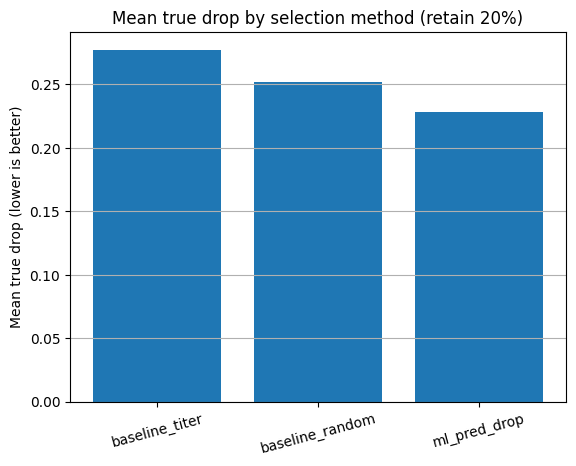

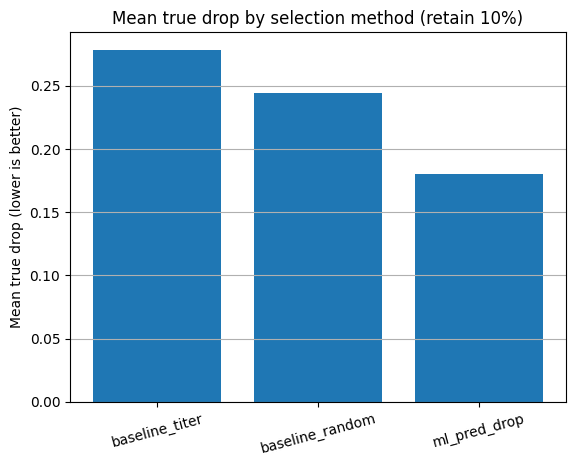

In [7]:
for frac in fractions:
    sub = results_df[results_df["retain_frac"] == frac].copy()
    plt.figure()
    plt.bar(sub["method"], sub["mean_true_drop"])
    plt.title(f"Mean true drop by selection method (retain {int(frac*100)}%)")
    plt.ylabel("Mean true drop (lower is better)")
    plt.xticks(rotation=15)
    plt.grid(True, axis="y")
    plt.show()

## 8) Evaluate late-stage titer from SQLite (optional)

To connect decisions to real CLD-like outocmes, we compute late-stage titer (average titer over passages 26-30) directly from the raw DB.

This sohws whether ML-guided selection improves not only stability labels, but also late-stage performance metrics.

In [8]:
# Helper: compute late mean titer from DB for a set of clone_ids
def fetch_late_mean_titer(conn, clone_list, late_start=26, late_end=30):
    placeholders = ",".join(["?"] * len(clone_list))
    query = f"""
    SELECT p.clone_id, AVG(ar.value) AS late_mean_titer
    FROM assay_result ar
    JOIN passage p ON p.passage_id = ar.passage_id
    WHERE ar.assay_type = 'titer'
      AND p.passage_number BETWEEN ? AND ?
      AND p.clone_id IN ({placeholders})
    GROUP BY p.clone_id
    """
    params = [late_start, late_end] + list(clone_list)
    return pd.read_sql_query(query, conn, params=params)

for frac in fractions:
    sel_ml = retain_top_fraction(test_table, "pred_drop", frac, higher_is_better=False)
    sel_titer = retain_top_fraction(test_table, "titer_mean", frac, higher_is_better=True)

    late_ml = fetch_late_mean_titer(conn, sel_ml["clone_id"].tolist())
    late_ti = fetch_late_mean_titer(conn, sel_titer["clone_id"].tolist())

    print(f"\nRetain {int(frac*100)}%")
    print("ML-guided late mean titer:", late_ml["late_mean_titer"].mean())
    print("Titer-baseline late mean titer:", late_ti["late_mean_titer"].mean())


Retain 20%
ML-guided late mean titer: 1.7790788205000243
Titer-baseline late mean titer: 2.8319091287223186

Retain 10%
ML-guided late mean titer: 1.7558034557004798
Titer-baseline late mean titer: 3.532133324047566


## Summary and interpretation

### What to look for
- **ml_pred_drop** should ideally produce lower mean_true_drop than baselines
- Top 10% should generally yield stronger stability but carries higher false-negative risk
- Top 20% is safer and often close in performance

### Why this matters
This simulation turns “a model” into “a decision policy” and quantifies impact.
This is the step where ML becomes useful for real CLD workflows.

## Close DB connection

In [9]:
conn.close()
print("DB connection closed.")

DB connection closed.
